# ICMR2024 - CheapFake Detection source code

# **Note:** Set input folder path

INPUT_FOLDER should has structure as same as requirement of organizer, contain "test.json" as follow:

INPUT_FOLDER\
├── test.json \
├── <folder_name> \
│ ├── 0.jpg \
│ ├── 1.png \
│ ├── 2.jpg \
│ ├── ...jpg

(With "<folder_name>/0.jpg" is an "img_local_path" in "test.json" for example.)

(**Recommend**: The dataset folder can be uploaded to Google Drive first then mount to the notebook)

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
%env INPUT_FOLDER=/content/drive/MyDrive/CheapFake/images_test_acm

env: INPUT_FOLDER=/content/drive/MyDrive/CheapFake/images_test_acm


# Preparation

In [3]:
#@title Pull source code

!git clone https://github.com/twelcone/icmr2024.git

Cloning into 'icmr2024'...
remote: Enumerating objects: 83, done.
remote: Counting objects: 100% (83/83), done.
remote: Compressing objects: 100% (62/62), done.
remote: Total 83 (delta 11), reused 79 (delta 10), pack-reused 0
Receiving objects: 100% (83/83), 9.25 MiB | 13.01 MiB/s, done.
Resolving deltas: 100% (11/11), done.


In [4]:
#@title Download LlaMa weight

!pip install -q --upgrade --no-cache-dir gdown
%cd /content/icmr2024/
!mkdir LLM && cd LLM && mkdir models
%cd /content/icmr2024/LLM/models
!gdown --fuzzy https://drive.google.com/file/d/1qXur8rs-FLFHJ8I_BdfwuywXP3X0JEhr/view?usp=sharing

/content/icmr2024
/content/icmr2024/LLM/models
Downloading...
From (original): https://drive.google.com/uc?id=1qXur8rs-FLFHJ8I_BdfwuywXP3X0JEhr
From (redirected): https://drive.google.com/uc?id=1qXur8rs-FLFHJ8I_BdfwuywXP3X0JEhr&confirm=t&uuid=a3c242cc-8942-4f30-b4bc-1049f63413eb
To: /content/icmr2024/LLM/models/mistral-7b-openorca.Q4_0.gguf
100% 4.11G/4.11G [01:24<00:00, 48.5MB/s]


In [5]:
#@title Install dependencies

!python -m spacy download en_core_web_sm
!pip install -q tqdm
!pip install -q -U sentence-transformers
!pip install -q selenium webdriver_manager
!pip install -q llama-cpp-python
!pip install -q pyyaml
!pip install -q ipdb
!pip install -q torch
!pip install -q clip diffusers accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 82.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.5/156.5 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 61.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 61.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 92.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 14.2 MB/s eta 0:00:00
     ━━━━

In [6]:
#@title Pull Detectron2 and GILL repository

%cd /content/icmr2024/
!git clone https://github.com/kohjingyu/gill.git
!git clone https://github.com/facebookresearch/detectron2.git
!scp -r /content/icmr2024/detectron2_changes/* /content/icmr2024/detectron2/detectron2

/content/icmr2024
Cloning into 'gill'...
remote: Enumerating objects: 244, done.
remote: Counting objects: 100% (96/96), done.
remote: Compressing objects: 100% (60/60), done.
remote: Total 244 (delta 57), reused 54 (delta 36), pack-reused 148
Receiving objects: 100% (244/244), 89.90 MiB | 13.91 MiB/s, done.
Resolving deltas: 100% (133/133), done.
Cloning into 'detectron2'...
remote: Enumerating objects: 15508, done.
remote: Counting objects: 100% (233/233), done.
remote: Compressing objects: 100% (193/193), done.
remote: Total 15508 (delta 66), reused 178 (delta 40), pack-reused 15275
Receiving objects: 100% (15508/15508), 6.39 MiB | 7.66 MiB/s, done.
Resolving deltas: 100% (11181/11181), done.


In [7]:
#@title Install detectron2

%cd /content/icmr2024/detectron2
!pip install -e ./ -q

/content/icmr2024/detectron2
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 21.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 71.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 17.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [8]:
#@title Install GILL

%env PYTHONPATH=$PYTHONPATH:/content/icmr2024/gill

env: PYTHONPATH=$PYTHONPATH:/content/icmr2024/gill


# Run experiment for Task 1 of Cheapfakes detection

## Set `OUTPUT_FOLDER`

The output folder will contain model metadata as well as the predicted results of each test case

The default is: `OUTPUT_FOLDER = "/content/icmr2024/output"`

(**Recommend:** Set the output folder into Google Drive in case the session crashes

In [3]:
%env OUTPUT_FOLDER = /content/drive/MyDrive/output/

env: OUTPUT_FOLDER=/content/drive/MyDrive/output/


## Run

In [16]:
%cd /content/icmr2024
!python /content/icmr2024/run.py

/content/icmr2024
2024-03-21 12:38:49.049564: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-21 12:38:49.100281: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-21 12:38:49.100335: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-21 12:38:49.101872: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-21 12:38:49.110007: I tensorflow/core/platfor

## Metrics summary

In [32]:
#@title Read csv log as dataframe
import os
import pandas as pd

log_file_path = os.path.join(os.environ["OUTPUT_FOLDER"], "results/log_result_our_methods.csv")
log_df = pd.read_csv(log_file_path)

Confusion Matrix


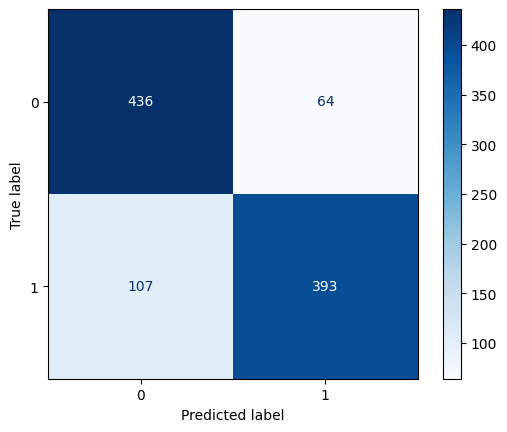

Accuracy: 0.829
Average Precision: 0.782925601750547
F1-Score: 0.8213166144200628


In [76]:
#@title Effectiveness

from sklearn.metrics import accuracy_score, average_precision_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


y_true = log_df["actual_context"].tolist()
y_pred = log_df["predicted_context"].tolist()

print("Confusion Matrix")
matrix = confusion_matrix(y_true, y_pred)
plot_matrix = ConfusionMatrixDisplay(confusion_matrix=matrix)
plot_matrix.plot(cmap=plt.cm.Blues)
plt.show()
print("==============================================================")
print(f"Accuracy: {accuracy_score(y_true, y_pred)}")
print("==============================================================")
print(f"Average Precision: {average_precision_score(y_true, y_pred)}")
print("==============================================================")
print(f"F1-Score: {f1_score(y_true, y_pred)}")

In [73]:
#@ title Efficiency

import numpy as np

all_cases_inference_time = log_df["inference_time"].to_numpy()

print(f"Total inference time (second) (on {len(log_df)} test cases): {np.sum(all_cases_inference_time)}")
print(f"Average inference time (second) per test case: {np.average(all_cases_inference_time)}")
print("==============================================================")
model_size = 0
model_params = 0
print("COSMOS base model:")
with open(os.path.join(os.environ["OUTPUT_FOLDER"], "log_model_info/cosmos_model.txt"), "r") as f:
    lines = f.readlines()
    model_params += int(lines[0].split(": ")[1])
    model_size += float(lines[1].split("| ")[1].split(" /")[0])
    for line in lines:
        line = line.replace("\n", "")
        print("-", line)
    print("\n")
print("Contextual model:")
with open(os.path.join(os.environ["OUTPUT_FOLDER"], "log_model_info/contextual_model.txt"), "r") as f:
    lines = f.readlines()
    model_params += int(lines[0].split(": ")[1])
    model_size += float(lines[1].split("| ")[1].split(" /")[0])
    for line in lines:
        line = line.replace("\n", "")
        print("-", line)
    print("\n")
print("GILL model:")
with open(os.path.join(os.environ["OUTPUT_FOLDER"], "log_model_info/gill_model.txt"), "r") as f:
    lines = f.readlines()
    model_params += int(lines[0].split(": ")[1])
    model_size += float(lines[1].split("| ")[1].split(" /")[0])
    for line in lines:
        line = line.replace("\n", "")
        print("-", line)
    print("\n")
print("LLM - LLaMa7B model:")
with open(os.path.join(os.environ["OUTPUT_FOLDER"], "log_model_info/llm_model.txt"), "r") as f:
    lines = f.readlines()
    param_prefix = "llm_load_print_meta: model params     = "
    size_prefix = "llm_load_print_meta: model size       = "
    for line in lines:
        if line.startswith(param_prefix):
            params_str = line.split(param_prefix)[1].replace("\n", "")
            model_params += float(params_str.split(" ")[0]) * 1e9
            print(f"- model params: {params_str}")
        if line.startswith(size_prefix):
            size_str = line.split(size_prefix)[1].split(" (")[0]
            c = 1073.741824
            mb_size = round((float(size_str.split(" ")[0]) * 1073.741824), 2)
            model_size += mb_size
            print(f"- model size: {size_str} | {mb_size} / MB")
            print("\n")

print("=> Summary:")
print(f"Number of parameters: {int(model_params)}")
print(f"Model Size: {model_size} MB")

Total inference time (second) (on 1000 test cases): 6997.371831178665
Average inference time (second) per test case: 6.997371831178665
COSMOS base model:
- model params: 2559576
- model size: 81906432 / bit | 10.24 / MB


Contextual model:
- model params: 109482240
- model size: 3503431680 / bit | 437.93 / MB


GILL model:
- model params: 7011733763
- model size: 112187740208 / bit | 14023.47 / MB


LLM - LLaMa7B model:
- model params: 7.24 B
- model size: 3.83 GiB | 4112.43 / MB


=> Summary:
Number of parameters: 14363775579
Model Size: 18584.07 MB
